In [1]:
import sys, os
from pathlib import Path
import importlib
from models import flooding_model

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from matplotlib.colors import ListedColormap


experiment_name = "WFV1_unet"
# Download val folder
path_to_dataset_folder = '.'
dataset_folder = os.path.join(path_to_dataset_folder, "worldfloods_v1_0_sample")
val_folder = os.path.join(dataset_folder, "val")

folder_name_model_weights = os.path.join(path_to_dataset_folder, experiment_name)

if not os.path.exists(folder_name_model_weights):
    import gdown
    gdown.download_folder(id="1Oup-qVD1U-re3lIQkw7TOKJsdu90blsk", quiet=False, use_cookies=False,
                          output=folder_name_model_weights)

if not os.path.exists(val_folder):
    import gdown
    os.makedirs(val_folder, exist_ok=True)
    # https://drive.google.com/drive/folders/1ogcNupGr0q6nLwS7BBQQ8PzILyONah12?usp=sharing
    gdown.download_folder(id="1ogcNupGr0q6nLwS7BBQQ8PzILyONah12", quiet=False, use_cookies=False,
                          output=val_folder)

Step 1: Get config

In [2]:
import sys, os
from pathlib import Path
import importlib
from models import flooding_model

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from matplotlib.colors import ListedColormap


experiment_name = "WFV1_unet"
# Download val folder
path_to_dataset_folder = '.'
dataset_folder = os.path.join(path_to_dataset_folder, "worldfloods_v1_0_sample")
val_folder = os.path.join(dataset_folder, "val")

folder_name_model_weights = os.path.join(path_to_dataset_folder, experiment_name)

if not os.path.exists(folder_name_model_weights):
    import gdown
    gdown.download_folder(id="1Oup-qVD1U-re3lIQkw7TOKJsdu90blsk", quiet=False, use_cookies=False,
                          output=folder_name_model_weights)

if not os.path.exists(val_folder):
    import gdown
    os.makedirs(val_folder, exist_ok=True)
    # https://drive.google.com/drive/folders/1ogcNupGr0q6nLwS7BBQQ8PzILyONah12?usp=sharing
    gdown.download_folder(id="1ogcNupGr0q6nLwS7BBQQ8PzILyONah12", quiet=False, use_cookies=False,
                          output=val_folder)

In [3]:
from ml4floods.models.config_setup import get_default_config


# config_fp = "train_models/training_flooding/config_rgbnir.json"
# config_fp = "./train_models/only_water/config_rgbnir_worldflood2_unet.json"
# config_fp = "./train_models/only_water/config_rgbnirh_worldflood2_res2vtunet_biou+dice.json"
config_fp = "./train_models/new_1015/config_rgbnir_worldfloodsup_res2vtunet.json"

config = get_default_config(config_fp)
config.data_params.data_params='ml4cc_data_lake'

# The max_tile_size param controls the max size of patches that are fed to the NN. If you're in a memory contrained environment set this value to 128
# config["model_params"]["max_tile_size"] = 128

Loaded Config for experiment:  new_1015
{   'data_params': {   'batch_size': 40,
                       'bucket_id': '',
                       'channel_configuration': 'bgri',
                       'download': {'test': True, 'train': True, 'val': True},
                       'filter_windows': {   'apply': False,
                                             'threshold_clouds': 0.5,
                                             'version': 'v1'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 16,
                       'path_to_splits': '/mnt/d/Flooding//worldfloods_v1_0',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '/mnt/d/Flooding/train_test_split.json',
                       'train_transformation': {'normalize': True},
                       'window_size': [256, 256]},
    'experiment_n

Step 2: Load pre-trained model

In [4]:
from pytorch_lightning.utilities.cloud_io import load
from models.flooding_model import WorldFloodsModel2, WorldFloodsModel_Sup, WorldFloodsModel
importlib.reload(flooding_model)

model = WorldFloodsModel_Sup(config.model_params)
# model = WorldFloodsModel_Sup(config.model_params)
# path_to_models = os.path.join(config.model_params.model_folder,config.experiment_name, "model_rgbnir.pt").replace("\\","/")
# path_to_models = os.path.join(config.model_params.model_folder,config.experiment_name, "model_rgbnir_worldflood2_unet.pt").replace("\\","/")
# path_to_models = os.path.join(config.model_params.model_folder,config.experiment_name, "model_rgbnirh_worldflood2_res2vtunet_biou+dice.pt").replace("\\","/")
path_to_models = os.path.join(config.model_params.model_folder,config.experiment_name, "model_rgbnir_worldfloodsup_res2vtunet.pt").replace("\\","/")


print(path_to_models)
model.load_state_dict(load(path_to_models))
model

model.eval()
model.to("cuda:1") # comment this line if your machine does not have GPU

train_models/new_1015/model_rgbnir_worldfloodsup_res2vtunet.pt


/home/hsu/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/cloud_io.py:41: LightningDeprecationWarning: `pytorch_lightning.utilities.cloud_io.load` has been deprecated in v1.8.0 and will be removed in v2.0.0. This function is internal but you can copy over its implementation.
  rank_zero_deprecation(


WorldFloodsModel_Sup(
  (network): Res2VTUnet(
    (h): RGB2HSV()
    (h_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (in_conv): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (cvt1): CvTblock(
      (conv_embed): Sequential(
        (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(4, 4), padding=(1, 1))
        (1): Rearrange('b c h w -> b (h w) c', h=64, w=64)
        (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (hue_embed): Sequential(
        (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(4, 4), padding=(1, 1))
        (1): Rearrange('b c h w -> b (h w) c', h=64, w=64)
        (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (transformer): Sequential(
        (0): Trans_depth(
          (layers): ModuleList(
            (0): TransformerBlock(
              (mha): Res2Attention(
                (res2): Res2Net(
                  (inconv): Sequential(
                    (0): Conv2d

In [5]:
from ml4floods.models.model_setup import get_model_inference_function
# from ml4.model_setup import get_model_inference_function

inference_function = get_model_inference_function(model, config,apply_normalization=True)

Getting model inference function


Step 3: Run Inference

In [6]:
def slice_tensor(tensor, size):
    slices = []
    _, height, width = tensor.shape
    x_slices = (width ) // size 
    y_slices = (height ) // size

    for i in range(x_slices):
        for j in range(y_slices):
            left = i * size
            upper = j * size
            right = min(left + size, width)
            lower = min(upper + size, height)
            slice = tensor[:, upper:lower, left:right]
            # print(slice.shape)
            slices.append(slice)

    return slices


def combine_slices(slices, tensor_size):
    _, height, width = tensor_size    
    x_slices = (width) // slices[0].shape[2] 
    y_slices = (height) // slices[0].shape[1] 
    combined_tensor = torch.zeros(3,height , width)
    
    for i in range(x_slices):
        for j in range(y_slices):
            slice_index = i * y_slices + j
            slice = slices[slice_index]
            left = i * slice.shape[2]
            upper = j * slice.shape[1]
            combined_tensor[:, upper:upper+slice.shape[1], left:left+slice.shape[2]] = slice

    return combined_tensor

In [7]:
from sklearn.metrics import confusion_matrix
def metrics_water (gt, pred):
    water_gt = torch.zeros_like(gt)
    water_gt[gt==2] = 1
    background_gt = torch.zeros_like(gt)
    background_gt[gt!=2] = 1

    water_pred = torch.zeros_like(pred)
    water_pred[pred==2] = 1
    background_pred = torch.zeros_like(pred)
    background_pred[pred!=2] = 1

    # value = water_gt-water_pred
    # print(len(torch.where(value == 1)[0]), len(torch.where(value == 0)[0]), len(torch.where(value == -1)[0]))
    tn, fp, fn, tp = confusion_matrix(water_gt.float().flatten(), water_pred.float().flatten()).ravel()
    # print(tn, fp, fn, tp)
    iou_water = tp/(tp+fp+fn)
    # print('iou_water',iou_water)
    precision_water = tp/(tp+fp)
    # print('precision_water', precision_water)
    recall_water = tp/(tp+fn)
    # print('recall_water', recall_water)
    f1_score_water = 2 * (precision_water*recall_water)/(precision_water+recall_water)

    tn, fp, fn, tp = confusion_matrix(background_gt.numpy().flatten(), background_pred.numpy().flatten()).ravel()
    # print(tn, fp, fn, tp)

    iou_background = tp/(tp+fp+fn)
    # print('iou_background',iou_background)
    precision_background = tp/(tp+fp)
    # print('precision_background', precision_background)
    recall_background = tp/(tp+fn)
    # print('recall_background', recall_background)
    f1_score_background = 2 * (precision_background*recall_background)/(precision_background+recall_background)
    
    miou = (iou_water + iou_background)*0.5
    # print('miou', miou)
    ap = (precision_water + precision_background)*0.5
    # print('map', ap)
    ar = (recall_water + recall_background)*0.5
    # print('mar', ar)
    af1 = (f1_score_water + f1_score_background)*0.5
    
    return {'miou_water': miou, 'map_water': ap, 'mar_water': ar, 'F1_score':af1}

In [8]:
def metrics_land (gt, pred):
    water_gt = torch.zeros_like(gt)
    water_gt[torch.logical_or(gt == 0, gt == 1)] = 1
    background_gt = torch.zeros_like(gt)
    background_gt[torch.logical_or(gt == 2, gt == 3)] = 1

    water_pred = torch.zeros_like(pred)
    water_pred[pred==1] = 1
    background_pred = torch.zeros_like(pred)
    background_pred[pred!=1] = 1

    # value = water_gt-water_pred
    # print(len(torch.where(value == 1)[0]), len(torch.where(value == 0)[0]), len(torch.where(value == -1)[0]))
    tn, fp, fn, tp = confusion_matrix(water_gt.float().flatten(), water_pred.float().flatten()).ravel()
    # print(tn, fp, fn, tp)
    iou_water = tp/(tp+fp+fn)
    # print('iou_water',iou_water)
    precision_water = tp/(tp+fp)
    # print('precision_water', precision_water)
    recall_water = tp/(tp+fn)
    # print('recall_water', recall_water)
    f1_score_water = 2 * (precision_water*recall_water)/(precision_water+recall_water)

    tn, fp, fn, tp = confusion_matrix(background_gt.numpy().flatten(), background_pred.numpy().flatten()).ravel()
    # print(tn, fp, fn, tp)

    iou_background = tp/(tp+fp+fn)
    # print('iou_background',iou_background)
    precision_background = tp/(tp+fp)
    # print('precision_background', precision_background)
    recall_background = tp/(tp+fn)
    # print('recall_background', recall_background)
    f1_score_background = 2 * (precision_background*recall_background)/(precision_background+recall_background)

    miou = (iou_water + iou_background)*0.5
    # print('miou', miou)
    ap = (precision_water + precision_background)*0.5
    # print('map', ap)
    ar = (recall_water + recall_background)*0.5
    # print('mar', ar)
    af1 = (f1_score_water + f1_score_background)*0.5
    
    return {'miou_land': miou, 'map_land': ap, 'mar_land': ar, 'F1_score':af1}

In [9]:
def metrics_cloud (gt, pred):
    water_gt = torch.zeros_like(gt)
    water_gt[gt==3] = 1
    background_gt = torch.zeros_like(gt)
    background_gt[gt!=3] = 1

    water_pred = torch.zeros_like(pred)
    water_pred[pred==3] = 1
    background_pred = torch.zeros_like(pred)
    background_pred[pred!=3] = 1

    # value = water_gt-water_pred
    # print(len(torch.where(value == 1)[0]), len(torch.where(value == 0)[0]), len(torch.where(value == -1)[0]))
    tn, fp, fn, tp = confusion_matrix(water_gt.float().flatten(), water_pred.float().flatten()).ravel()
    # print(tn, fp, fn, tp)
    iou_water = tp/(tp+fp+fn)
    # print('iou_water',iou_water)
    precision_water = tp/(tp+fp)
    # print('precision_water', precision_water)
    recall_water = tp/(tp+fn)
    # print('recall_water', recall_water)
    f1_score_water = 2 * (precision_water*recall_water)/(precision_water+recall_water)

    tn, fp, fn, tp = confusion_matrix(background_gt.numpy().flatten(), background_pred.numpy().flatten()).ravel()
    # print(tn, fp, fn, tp)

    iou_background = tp/(tp+fp+fn)
    # print('iou_background',iou_background)
    precision_background = tp/(tp+fp)
    # print('precision_background', precision_background)
    recall_background = tp/(tp+fn)
    # print('recall_background', recall_background)
    f1_score_background = 2 * (precision_background*recall_background)/(precision_background+recall_background)

    miou = (iou_water + iou_background)*0.5
    # print('miou', miou)
    ap = (precision_water + precision_background)*0.5
    # print('map', ap)
    ar = (recall_water + recall_background)*0.5
    # print('mar', ar)
    af1 = (f1_score_water + f1_score_background)*0.5
    
    return {'miou_cloud': miou, 'map_cloud': ap, 'mar_cloud':ar, 'F1_score':af1}

torch.Size([4, 997, 977]) torch.float32 <class 'torch.Tensor'> | 0.00, 0.00,-73.93|
| 0.00,-0.00, 18.54|
| 0.00, 0.00, 1.00|


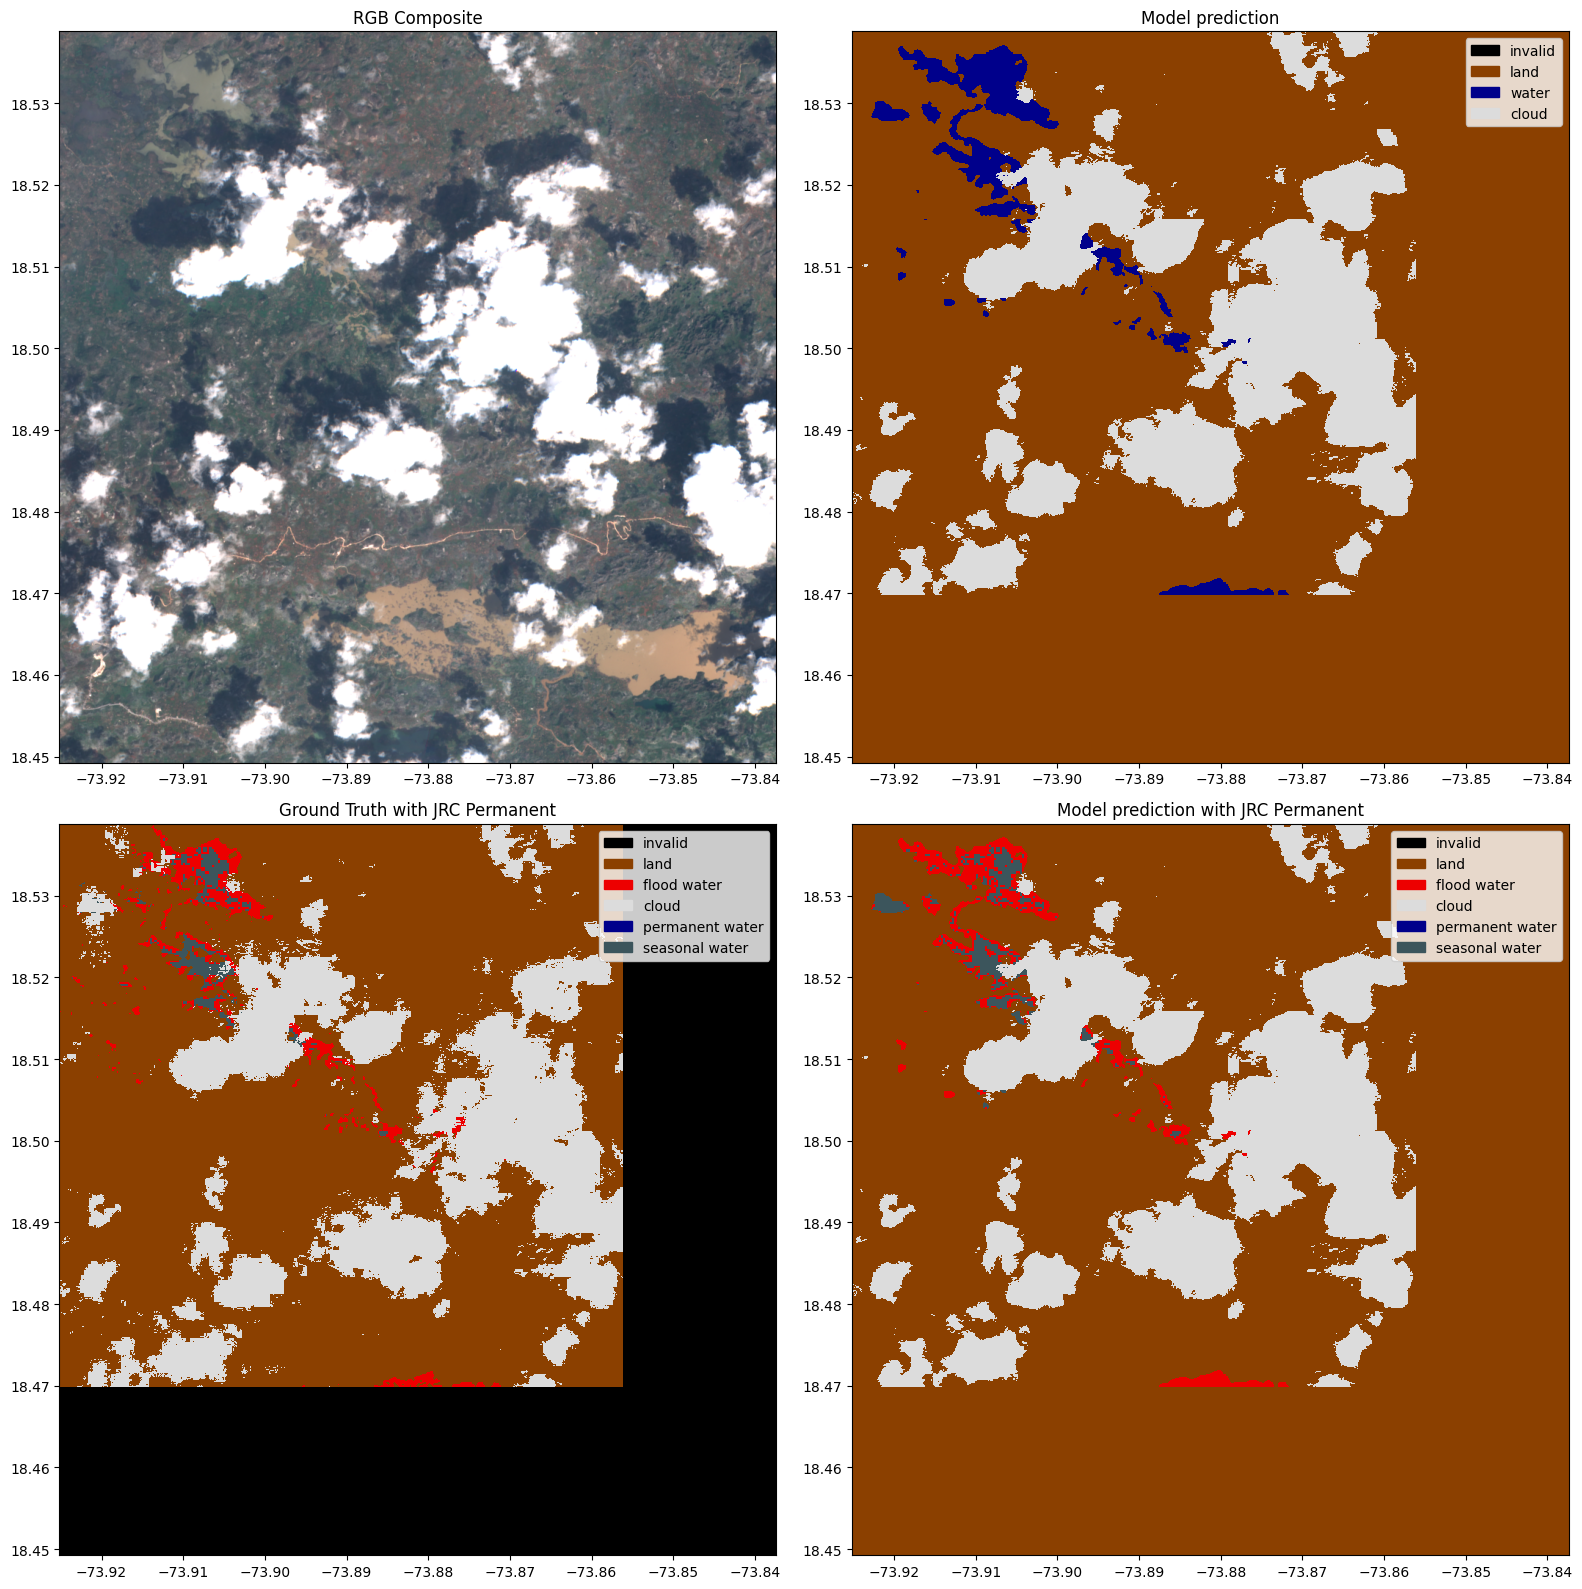

In [10]:
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt
# os.environ['GS_USER_PROJECT'] = 'myprojectname'

channel_configuration = config.model_params.hyperparameters.channel_configuration

dataset_folder = "./worldfloods_v1_0_sample/"
event_id = "RS2_20161008_Water_Extent_Corail_Pestel.tif"
tiff_s2 = os.path.join(dataset_folder, "val", "S2", event_id)
# print('s2', tiff_s2.shape, type(tiff_s2))
tiff_gt = os.path.join(dataset_folder, "val", "gt", event_id)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "val", "PERMANENTWATERJRC", event_id)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)
print(torch_inputs.shape, torch_inputs.dtype, type(torch_inputs), transform)
# Make predictions
sliced_images = slice_tensor(torch_inputs, size=256)
# print(sliced_images[0].shape)
outs = []
for i in sliced_images:
    outputs = inference_function(i.unsqueeze(0))[0] # (num_classes, h, w)
    # print(outputs.shape)
    outs.append(outputs)
    
recombined_image = combine_slices(outs, torch_inputs.shape)
prediction = torch.argmax(recombined_image, dim=0).long() # (h, w)
# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0
# print(prediction.unique())

# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])

sliced_floods = slice_tensor(torch_targets, size=256)
recombined_floods = combine_slices(sliced_floods, torch_inputs.shape)    
# print(torch.unique(recombined_floods))
sliced_water = slice_tensor(torch_permanent_water, size=256)
recombined_water = combine_slices(sliced_water, torch_inputs.shape)    
# print(torch.unique(recombined_water))

# Plot
fig, axs = plt.subplots(2,2, figsize=(16,16))
plot_utils.plot_rgb_image(torch_inputs.squeeze(0), transform=transform, ax=axs[0,0], channel_configuration=channel_configuration)
axs[0,0].set_title("RGB Composite")
# plot_utils.plot_gt_v1(recombined_floods, transform=transform, title = "Groud truth", ax=axs[0,1])
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, ax=axs[0,1])
axs[0,1].set_title("Model prediction")

# axs[0,1].set_title("SWIR1,NIR,R Composite")
plot_utils.plot_gt_v1_with_permanent(recombined_floods, recombined_water, window=window, transform=transform, ax=axs[1,0])
axs[1,0].set_title("Ground Truth with JRC Permanent")
plot_utils.plot_gt_v1_with_permanent(prediction.unsqueeze(0), recombined_water, window=window, transform=transform, ax=axs[1,1])
axs[1,1].set_title("Model prediction with JRC Permanent")
plt.tight_layout()

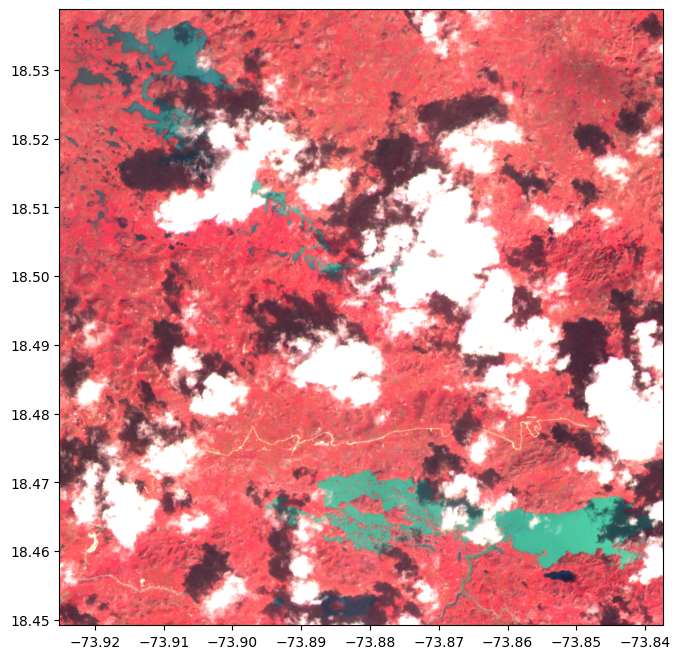

<Axes: >

In [11]:
import rasterio
from rasterio.plot import show

plt.figure(figsize=(12,8))
plot_utils.plot_rgb_image(torch_inputs, transform=transform)

In [12]:
pred = prediction  # [1, 2, 3]
# print(pred.shape, pred.unique())
gt = recombined_floods[0,:,:]  # [0., 1., 2., 3.]
# print(gt.shape, gt.unique())
water = metrics_water(gt, pred)
print(water)
land = metrics_land(gt, pred)
print(land)
cloud = metrics_cloud(gt, pred)
print(cloud)
# score = F1_score(gt, pred)
# print(score)

{'miou_water': 0.7323318556995362, 'map_water': 0.7970807185657096, 'mar_water': 0.8476678701626941, 'F1_score': 0.8202809521704708}
{'miou_land': 0.8871764581843218, 'map_land': 0.9251115268979815, 'mar_land': 0.953928498670711, 'F1_score': 0.9387079082924885}
{'miou_cloud': 0.9083589765247808, 'map_cloud': 0.9385665627660444, 'mar_cloud': 0.9643304745351982, 'F1_score': 0.9508722574288612}


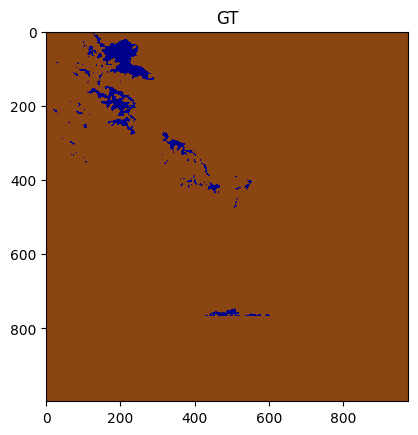

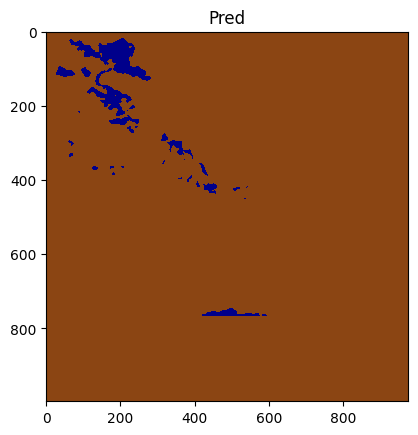

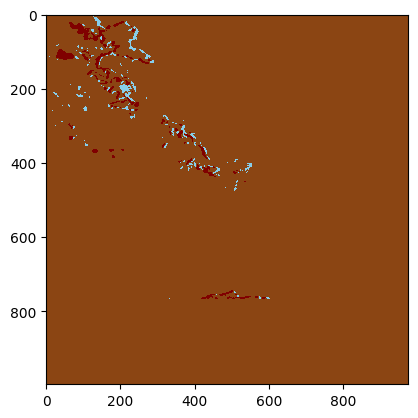

In [13]:
water_gt = torch.zeros_like(recombined_floods[1,:,:])
water = (recombined_floods[0,:,:] == 2) & (recombined_floods[1,:,:] == 2) & (recombined_floods[2,:,:] == 2)
water_gt[water] = 1
cmap = ListedColormap(['SaddleBrown', 'DarkBlue'])
plt.title('GT')
plt.imshow(water_gt, cmap=cmap)
plt.show()

water_pred = torch.zeros_like(prediction[:,:])
water_pred[prediction==2] = 1
cmap = ListedColormap(['SaddleBrown', 'DarkBlue'])
plt.title('Pred')
plt.imshow(water_pred, cmap=cmap)
plt.show()

water_diff = water_pred - water_gt
cmap = ListedColormap(['SkyBlue','SaddleBrown','Maroon'])
plt.imshow(water_diff, cmap=cmap)
plt.show()

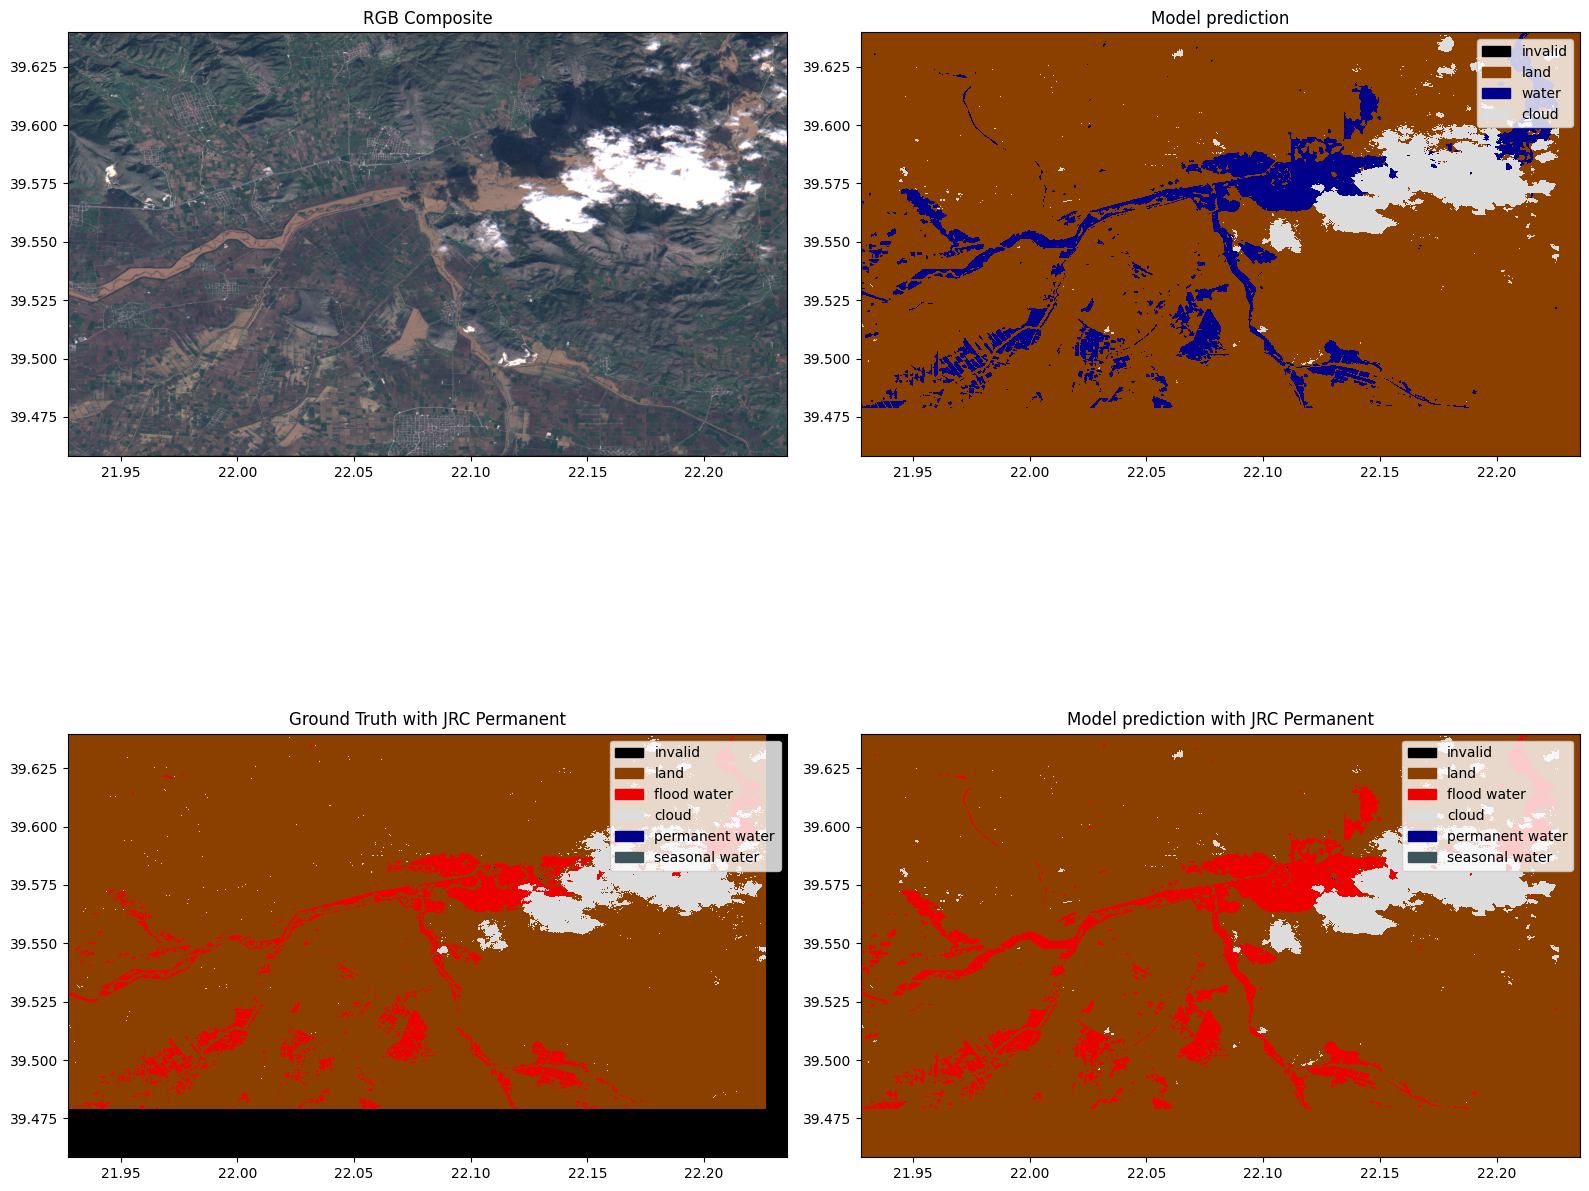

In [14]:
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt
# os.environ['GS_USER_PROJECT'] = 'myprojectname'

channel_configuration = config.model_params.hyperparameters.channel_configuration

dataset_folder = "./worldfloods_v1_0_sample/"
event_id = "EMSR271_02FARKADONA_DEL_v1_observed_event_a.tif"
tiff_s2 = os.path.join(dataset_folder, "val", "S2", event_id)
tiff_gt = os.path.join(dataset_folder, "val", "gt", event_id)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "val", "PERMANENTWATERJRC", event_id)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)
# print(torch_inputs.shape)
# Make predictions
sliced_images = slice_tensor(torch_inputs, size=256)
# print(sliced_images[0])
outs = []
for i in sliced_images:
    outputs = inference_function(i.unsqueeze(0))[0] # (num_classes, h, w)
    # print(len(outputs))
    outs.append(outputs)
# print(sliced_images[8])
recombined_image = combine_slices(outs, torch_inputs.shape)    

prediction = torch.argmax(recombined_image, dim=0).long() # (h, w)
# print(prediction.shape)
# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0
# print(prediction.shape)

# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])
sliced_floods = slice_tensor(torch_targets, size=256)
recombined_floods = combine_slices(sliced_floods, torch_inputs.shape)    
# print(torch.unique(recombined_floods))
sliced_water = slice_tensor(torch_permanent_water, size=256)
recombined_water = combine_slices(sliced_water, torch_inputs.shape)   


# Plot
fig, axs = plt.subplots(2,2, figsize=(16,16))
plot_utils.plot_rgb_image(torch_inputs.squeeze(0), transform=transform, ax=axs[0,0], channel_configuration=channel_configuration)
axs[0,0].set_title("RGB Composite")
# plot_utils.plot_gt_v1(recombined_floods, transform=transform, title = "Groud truth", ax=axs[0,1])
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, ax=axs[0,1])
axs[0,1].set_title("Model prediction")

# axs[0,1].set_title("SWIR1,NIR,R Composite")
plot_utils.plot_gt_v1_with_permanent(recombined_floods, recombined_water, window=window, transform=transform, ax=axs[1,0])
axs[1,0].set_title("Ground Truth with JRC Permanent")
plot_utils.plot_gt_v1_with_permanent(prediction.unsqueeze(0), recombined_water, window=window, transform=transform, ax=axs[1,1])
axs[1,1].set_title("Model prediction with JRC Permanent")
plt.tight_layout()

torch.Size([4, 2020, 3431])
0 tensor(250.3330) tensor(0.) tensor(45.5134) tensor(22.6890)
1 tensor(248.6783) tensor(0.) tensor(43.4444) tensor(23.0102)
2 tensor(255.) tensor(0.) tensor(47.1414) tensor(26.2620)
3 tensor(254.7136) tensor(0.) tensor(51.7829) tensor(29.6093)


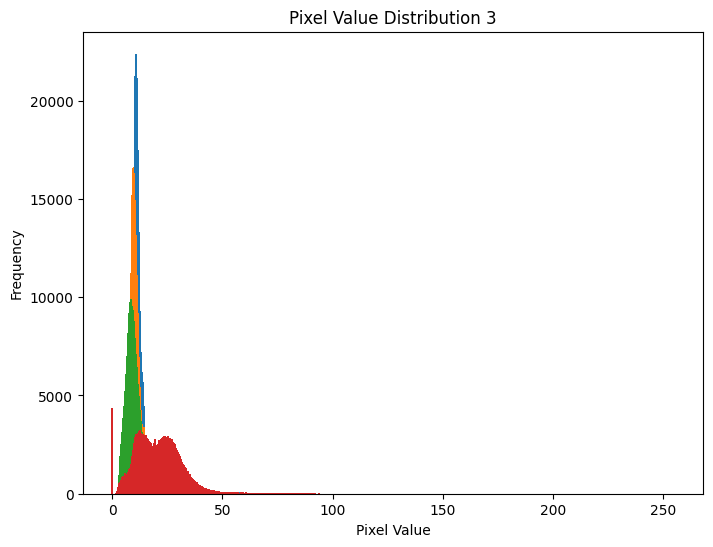

In [15]:
C, H, W = torch_inputs.shape
new_val = (torch_inputs-torch_inputs.min())/(torch_inputs.max()-torch_inputs.min())*255
print(new_val.shape)
plt.figure(figsize=(8, 6))
for channel in range(C):
    values, counts = torch.unique(new_val[channel, :, :], return_counts = True)
    # print(channel, values, counts)
    print(channel, torch.max(values), torch.min(values), torch.mean(values), torch.std(values))

    plt.bar(values, counts)
    plt.title(f'Pixel Value Distribution {channel}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.show()

In [16]:
pred = prediction  # [1, 2, 3]
# print(pred.shape, pred.unique())
gt = recombined_floods[0,:,:]  # [0., 1., 2., 3.]
# print(gt.shape, gt.unique())
water = metrics_water(gt, pred)
print(water)
land = metrics_land(gt, pred)
print(land)
cloud = metrics_cloud(gt, pred)
print(cloud)
# score = F1_score(gt, pred)
# print(score)

{'miou_water': 0.7665729805775741, 'map_water': 0.8050346044804697, 'mar_water': 0.9298204544250265, 'F1_score': 0.8544873194766847}
{'miou_land': 0.8112557951777994, 'map_land': 0.8506308273377401, 'mar_land': 0.9440717441955491, 'F1_score': 0.8895380999470452}
{'miou_cloud': 0.8951068809644017, 'map_cloud': 0.9199011990010192, 'mar_cloud': 0.9670046017050238, 'F1_score': 0.9420543164356591}


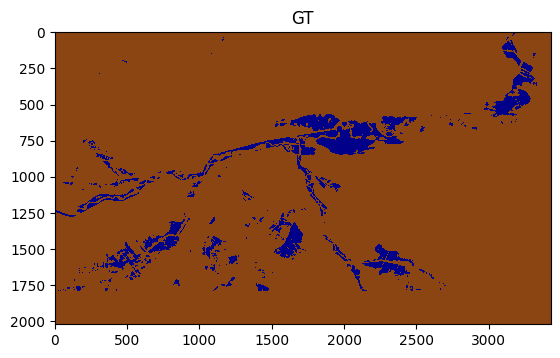

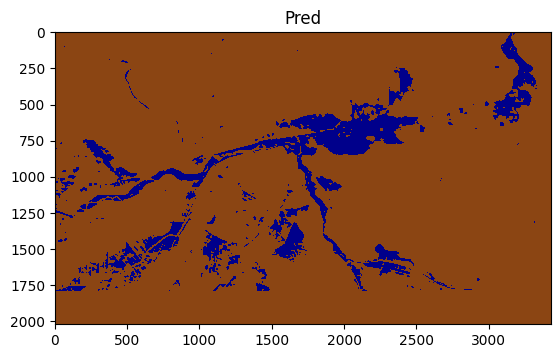

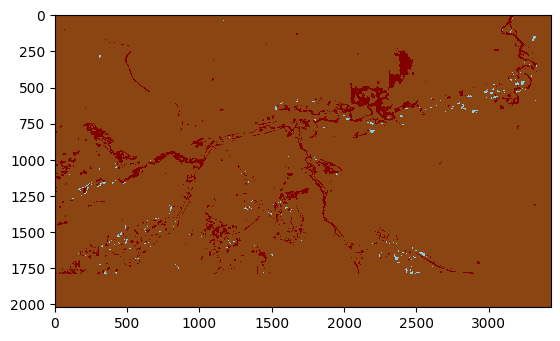

In [17]:
water_gt = torch.zeros_like(recombined_floods[1,:,:])
water = (recombined_floods[0,:,:] == 2) & (recombined_floods[1,:,:] == 2) & (recombined_floods[2,:,:] == 2)
water_gt[water] = 1
cmap = ListedColormap(['SaddleBrown', 'DarkBlue'])
plt.title('GT')
plt.imshow(water_gt, cmap=cmap)
plt.show()

water_pred = torch.zeros_like(prediction[:,:])
water_pred[prediction==2] = 1
cmap = ListedColormap(['SaddleBrown', 'DarkBlue'])
plt.title('Pred')
plt.imshow(water_pred, cmap=cmap)
plt.show()

water_diff = water_pred - water_gt
cmap = ListedColormap(['SkyBlue','SaddleBrown','Maroon'])
plt.imshow(water_diff, cmap=cmap)
plt.show()

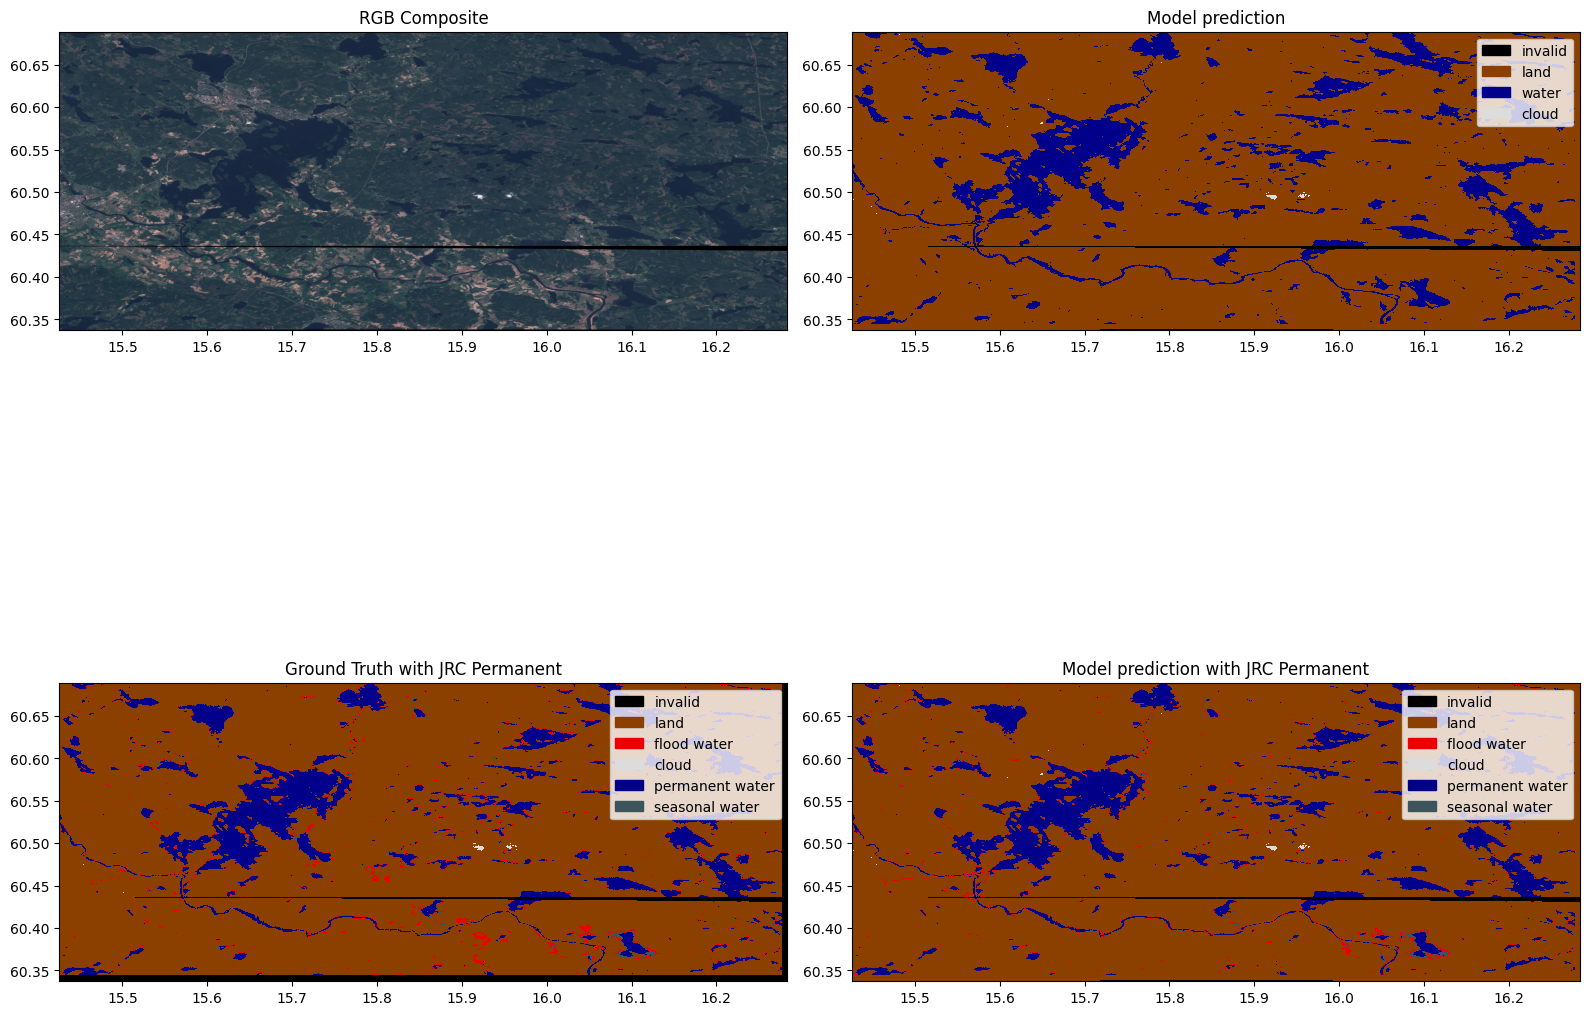

In [18]:
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt
# os.environ['GS_USER_PROJECT'] = 'myprojectname'

channel_configuration = config.model_params.hyperparameters.channel_configuration

dataset_folder = "./worldfloods_v1_0_sample/"
event_id = "EMSR280_03FALUN_DEL_MONIT06_v2_observed_event_a.tif"
tiff_s2 = os.path.join(dataset_folder, "val", "S2", event_id)
tiff_gt = os.path.join(dataset_folder, "val", "gt", event_id)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "val", "PERMANENTWATERJRC", event_id)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)
# print(torch_inputs.shape)
# Make predictions
sliced_images = slice_tensor(torch_inputs, size=256)
# print(sliced_images[0])
outs = []
for i in sliced_images:
    outputs = inference_function(i.unsqueeze(0))[0] # (num_classes, h, w)
    # print(len(outputs))
    outs.append(outputs)
# print(sliced_images[8])
recombined_image = combine_slices(outs, torch_inputs.shape)    

prediction = torch.argmax(recombined_image, dim=0).long() # (h, w)
# print(prediction.shape)
# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0
# print(prediction.shape)

# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])
sliced_floods = slice_tensor(torch_targets, size=256)
recombined_floods = combine_slices(sliced_floods, torch_inputs.shape)    
# print(torch.unique(recombined_floods))
sliced_water = slice_tensor(torch_permanent_water, size=256)
recombined_water = combine_slices(sliced_water, torch_inputs.shape)   

# Plot
fig, axs = plt.subplots(2,2, figsize=(16,16))
# print(torch_inputs[0, :100, :100])
plot_utils.plot_rgb_image(torch_inputs.squeeze(0), transform=transform, ax=axs[0,0], channel_configuration=channel_configuration)
axs[0,0].set_title("RGB Composite")
# plot_utils.plot_gt_v1(recombined_floods, transform=transform, title = "Groud truth", ax=axs[0,1])
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, ax=axs[0,1])
axs[0,1].set_title("Model prediction")

# axs[0,1].set_title("SWIR1,NIR,R Composite")
plot_utils.plot_gt_v1_with_permanent(recombined_floods, recombined_water, window=window, transform=transform, ax=axs[1,0])
axs[1,0].set_title("Ground Truth with JRC Permanent")
plot_utils.plot_gt_v1_with_permanent(prediction.unsqueeze(0), recombined_water, window=window, transform=transform, ax=axs[1,1])
axs[1,1].set_title("Model prediction with JRC Permanent")
plt.tight_layout()

In [19]:
pred = prediction  # [1, 2, 3]
# print(pred.shape, pred.unique())
gt = recombined_floods[0,:,:]  # [0., 1., 2., 3.]
# print(gt.shape, gt.unique())
water = metrics_water(gt, pred)
print(water)
land = metrics_land(gt, pred)
print(land)
cloud = metrics_cloud(gt, pred)
print(cloud)
# score = F1_score(gt, pred)
# print(score)

{'miou_water': 0.9337027296640512, 'map_water': 0.969757606910932, 'mar_water': 0.9604866963582873, 'F1_score': 0.965056946224301}
{'miou_land': 0.8991568604993948, 'map_land': 0.9363224113797188, 'mar_land': 0.954971241427335, 'F1_score': 0.945364606487086}
{'miou_cloud': 0.8106130548196204, 'map_cloud': 0.8477620593434895, 'mar_cloud': 0.9266888565966991, 'F1_score': 0.8832009014216629}


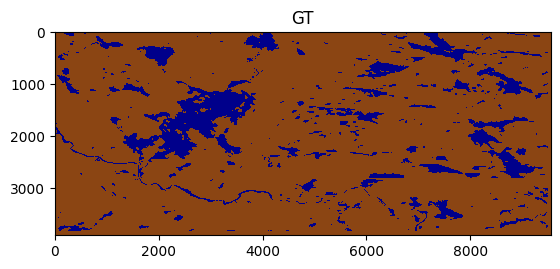

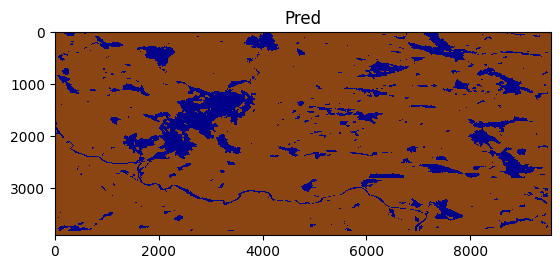

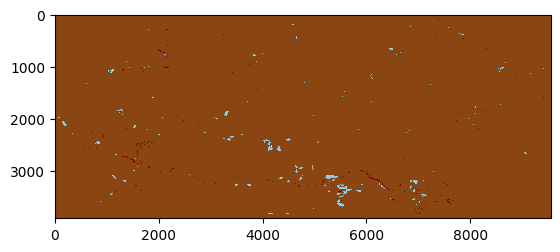

In [20]:
water_gt = torch.zeros_like(recombined_floods[1,:,:])
water = (recombined_floods[0,:,:] == 2) & (recombined_floods[1,:,:] == 2) & (recombined_floods[2,:,:] == 2)
water_gt[water] = 1
cmap = ListedColormap(['SaddleBrown', 'DarkBlue'])
plt.title('GT')
plt.imshow(water_gt, cmap=cmap)
plt.show()

water_pred = torch.zeros_like(prediction[:,:])
water_pred[prediction==2] = 1
cmap = ListedColormap(['SaddleBrown', 'DarkBlue'])
plt.title('Pred')
plt.imshow(water_pred, cmap=cmap)
plt.show()

water_diff = water_pred - water_gt
cmap = ListedColormap(['SkyBlue','SaddleBrown','Maroon'])
plt.imshow(water_diff, cmap=cmap)
plt.show()

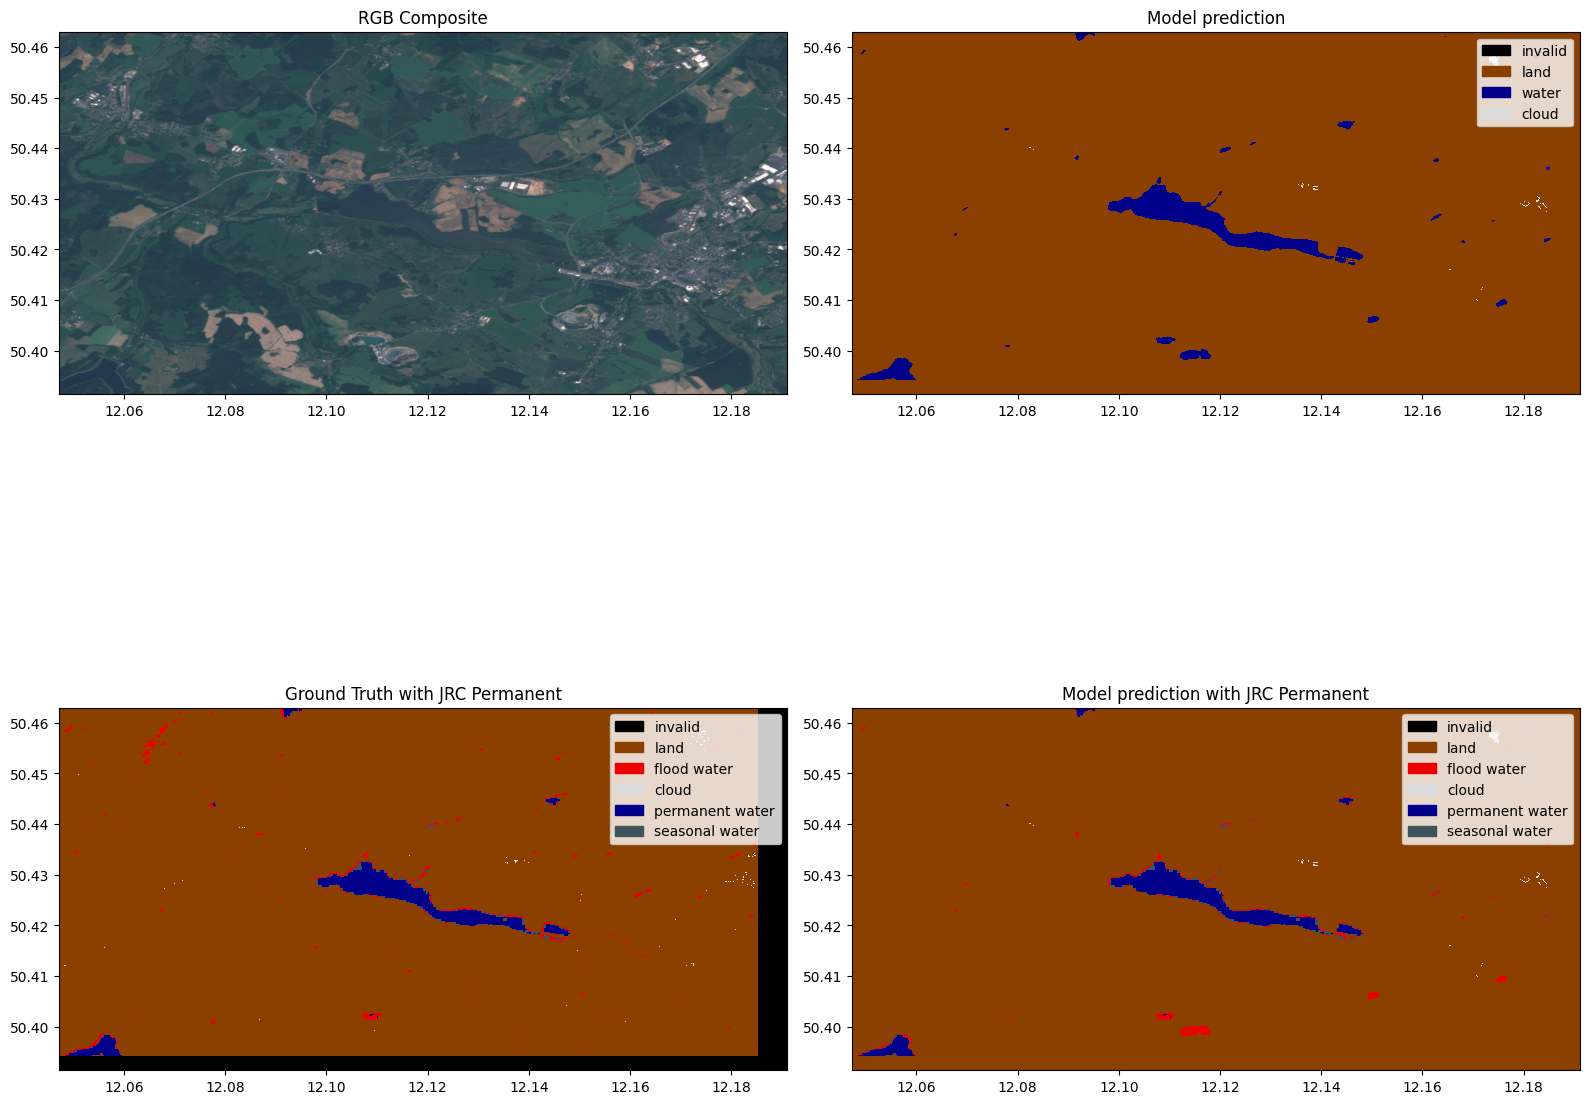

In [21]:
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt
# os.environ['GS_USER_PROJECT'] = 'myprojectname'

channel_configuration = config.model_params.hyperparameters.channel_configuration

dataset_folder = "./worldfloods_v1_0_sample/"
event_id = "EMSR287_05MAGWITZ_DEL_v1_observed_event_a.tif"
tiff_s2 = os.path.join(dataset_folder, "val", "S2", event_id)
tiff_gt = os.path.join(dataset_folder, "val", "gt", event_id)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "val", "PERMANENTWATERJRC", event_id)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)
# print(torch_inputs.shape)
# Make predictions
sliced_images = slice_tensor(torch_inputs, size=256)
# print(sliced_images[0])
outs = []
for i in sliced_images:
    outputs = inference_function(i.unsqueeze(0))[0] # (num_classes, h, w)
    # print(len(outputs))
    outs.append(outputs)
# print(sliced_images[8])
recombined_image = combine_slices(outs, torch_inputs.shape)    

prediction = torch.argmax(recombined_image, dim=0).long() # (h, w)
# print(prediction.shape)
# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0
# print(prediction.shape)

# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])
sliced_floods = slice_tensor(torch_targets, size=256)
recombined_floods = combine_slices(sliced_floods, torch_inputs.shape)    
# print(torch.unique(recombined_floods))
sliced_water = slice_tensor(torch_permanent_water, size=256)
recombined_water = combine_slices(sliced_water, torch_inputs.shape)   

# Plot
fig, axs = plt.subplots(2,2, figsize=(16,16))
plot_utils.plot_rgb_image(torch_inputs.squeeze(0), transform=transform, ax=axs[0,0], channel_configuration=channel_configuration)
axs[0,0].set_title("RGB Composite")
# plot_utils.plot_gt_v1(recombined_floods, transform=transform, title = "Groud truth", ax=axs[0,1])
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, ax=axs[0,1])
axs[0,1].set_title("Model prediction")

# axs[0,1].set_title("SWIR1,NIR,R Composite")
plot_utils.plot_gt_v1_with_permanent(recombined_floods, recombined_water, window=window, transform=transform, ax=axs[1,0])
axs[1,0].set_title("Ground Truth with JRC Permanent")
plot_utils.plot_gt_v1_with_permanent(prediction.unsqueeze(0), recombined_water, window=window, transform=transform, ax=axs[1,1])
axs[1,1].set_title("Model prediction with JRC Permanent")
plt.tight_layout()

In [22]:
pred = prediction  # [1, 2, 3]
# print(pred.shape, pred.unique())
gt = recombined_floods[0,:,:]  # [0., 1., 2., 3.]
# print(gt.shape, gt.unique())
water = metrics_water(gt, pred)
print(water)
land = metrics_land(gt, pred)
print(land)
cloud = metrics_cloud(gt, pred)
print(cloud)
# score = F1_score(gt, pred)
# print(score)

{'miou_water': 0.8844634343143696, 'map_water': 0.9520326565624961, 'mar_water': 0.9194268417344234, 'F1_score': 0.9350875771920275}
{'miou_land': 0.8734943748604197, 'map_land': 0.9431222428233879, 'mar_land': 0.9141008550852804, 'F1_score': 0.9280935224201154}
{'miou_cloud': 0.5583835136037044, 'map_cloud': 0.5925357913224241, 'mar_cloud': 0.621320018164273, 'F1_score': 0.6049853901563484}


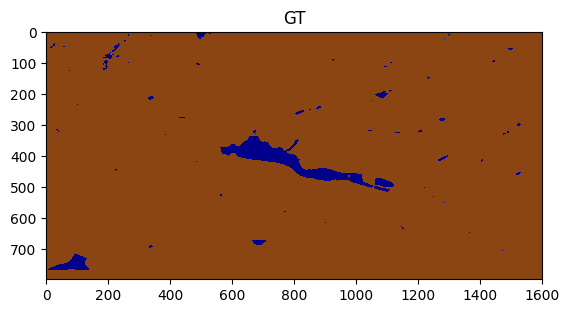

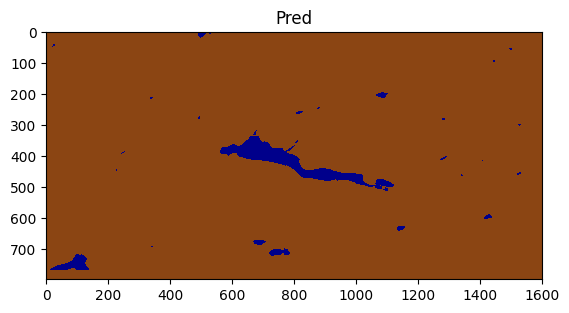

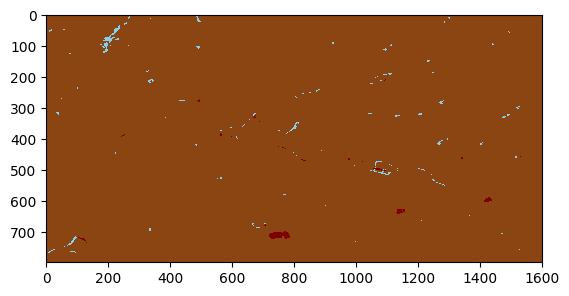

In [23]:
water_gt = torch.zeros_like(recombined_floods[1,:,:])
water = (recombined_floods[0,:,:] == 2) & (recombined_floods[1,:,:] == 2) & (recombined_floods[2,:,:] == 2)
water_gt[water] = 1
cmap = ListedColormap(['SaddleBrown', 'DarkBlue'])
plt.title('GT')
plt.imshow(water_gt, cmap=cmap)
plt.show()

water_pred = torch.zeros_like(prediction[:,:])
water_pred[prediction==2] = 1
cmap = ListedColormap(['SaddleBrown', 'DarkBlue'])
plt.title('Pred')
plt.imshow(water_pred, cmap=cmap)
plt.show()

water_diff = water_pred - water_gt
cmap = ListedColormap(['SkyBlue','SaddleBrown','Maroon'])
plt.imshow(water_diff, cmap=cmap)
plt.show()

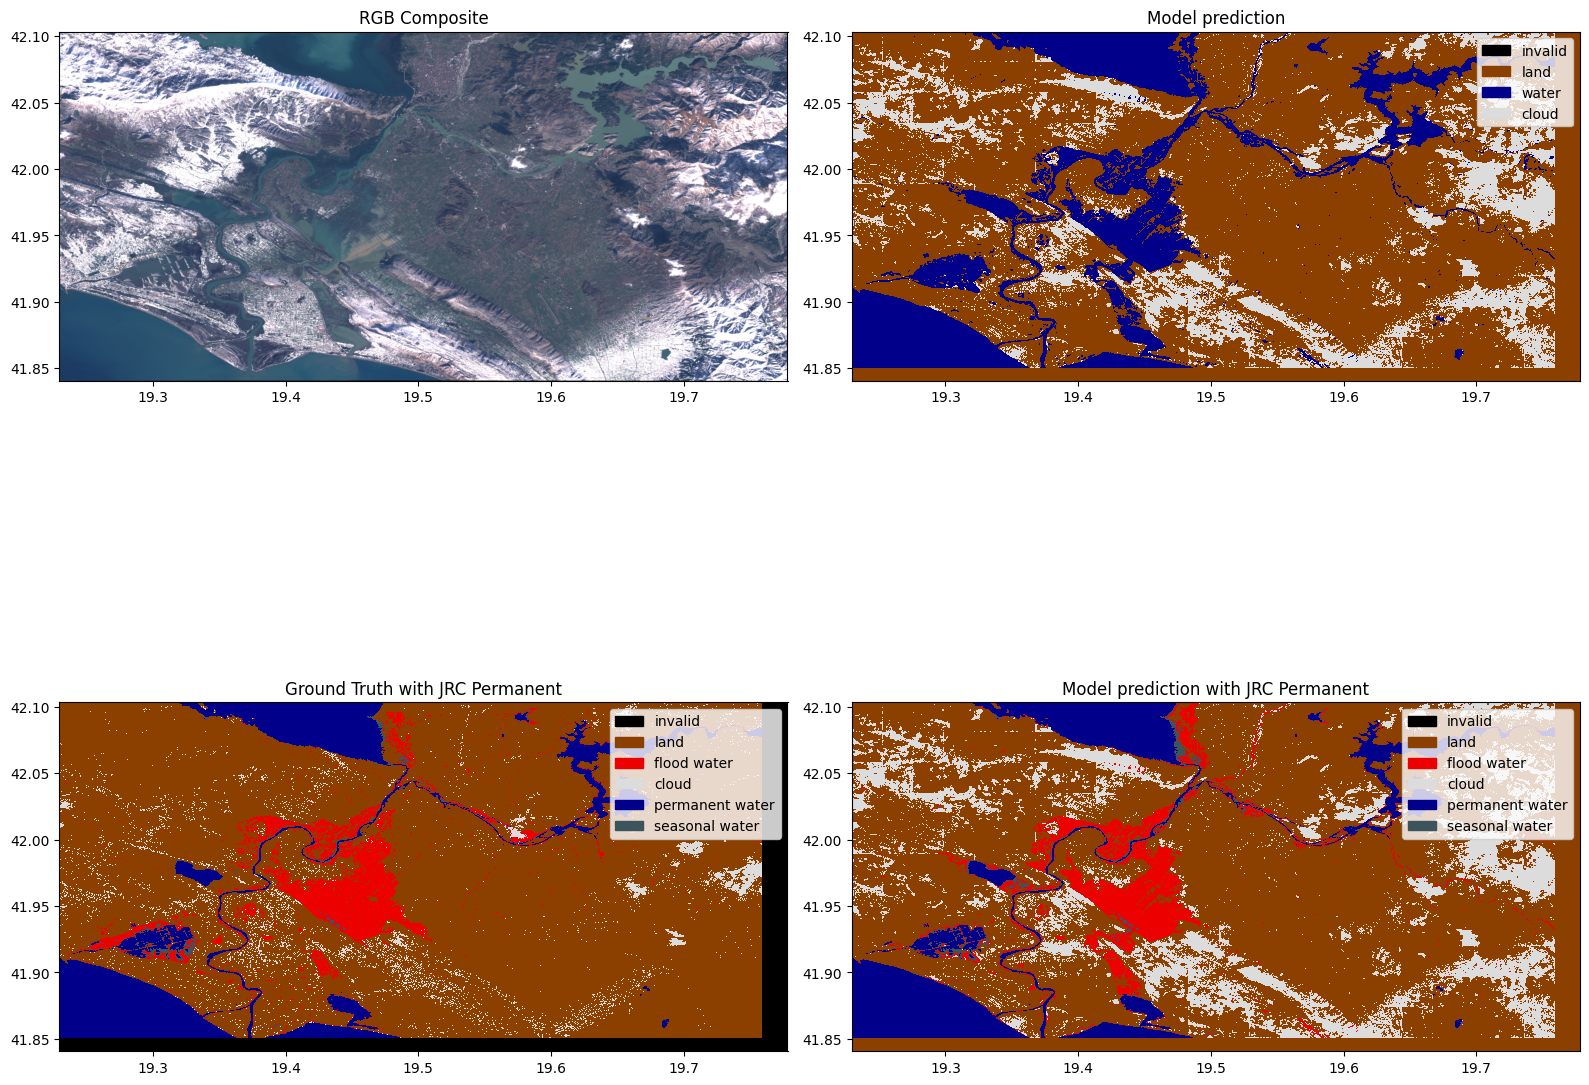

In [24]:
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt
# os.environ['GS_USER_PROJECT'] = 'myprojectname'

channel_configuration = config.model_params.hyperparameters.channel_configuration

dataset_folder = "./worldfloods_v1_0_sample/"
event_id = "EMSR501_AOI01_DEL_MONIT01_r1_v1.tif"
tiff_s2 = os.path.join(dataset_folder, "tiffs_for_inference", "S2", event_id)
tiff_gt = os.path.join(dataset_folder, "tiffs_for_inference", "GT","V_1_1", event_id)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "tiffs_for_inference", "JRC", event_id)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)
# print(torch_inputs.shape)
# Make predictions
sliced_images = slice_tensor(torch_inputs, size=256)
# print(sliced_images[0])
outs = []
for i in sliced_images:
    outputs = inference_function(i.unsqueeze(0))[0] # (num_classes, h, w)
    # print(len(outputs))
    outs.append(outputs)
# print(sliced_images[8])
recombined_image = combine_slices(outs, torch_inputs.shape)    

prediction = torch.argmax(recombined_image, dim=0).long() # (h, w)
# print(prediction.shape)
# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0
# print(prediction.shape)

# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])
sliced_floods = slice_tensor(torch_targets, size=256)
recombined_floods = combine_slices(sliced_floods, torch_inputs.shape)    
# print(torch.unique(recombined_floods))
sliced_water = slice_tensor(torch_permanent_water, size=256)
recombined_water = combine_slices(sliced_water, torch_inputs.shape)   

# Plot
fig, axs = plt.subplots(2,2, figsize=(16,16))
plot_utils.plot_rgb_image(torch_inputs.squeeze(0), transform=transform, ax=axs[0,0], channel_configuration=channel_configuration)
axs[0,0].set_title("RGB Composite")
# plot_utils.plot_gt_v1(recombined_floods, transform=transform, title = "Groud truth", ax=axs[0,1])
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, ax=axs[0,1])
axs[0,1].set_title("Model prediction")

# axs[0,1].set_title("SWIR1,NIR,R Composite")
plot_utils.plot_gt_v1_with_permanent(recombined_floods, recombined_water, window=window, transform=transform, ax=axs[1,0])
axs[1,0].set_title("Ground Truth with JRC Permanent")
plot_utils.plot_gt_v1_with_permanent(prediction.unsqueeze(0), recombined_water, window=window, transform=transform, ax=axs[1,1])
axs[1,1].set_title("Model prediction with JRC Permanent")
plt.tight_layout()

In [25]:
pred = prediction  # [1, 2, 3]
# print(pred.shape, pred.unique())
gt = recombined_floods[0,:,:]  # [0., 1., 2., 3.]
# print(gt.shape, gt.unique())
water = metrics_water(gt, pred)
print(water)
land = metrics_land(gt, pred)
print(land)
cloud = metrics_cloud(gt, pred)
print(cloud)
# score = F1_score(gt, pred)
# print(score)

{'miou_water': 0.862424097139494, 'map_water': 0.9199177772572054, 'mar_water': 0.9273218980869038, 'F1_score': 0.9235677795474795}
{'miou_land': 0.6402084014083712, 'map_land': 0.7443849101141755, 'mar_land': 0.8460101035694816, 'F1_score': 0.7698201701346445}
{'miou_cloud': 0.5056277754141134, 'map_cloud': 0.5746777112684878, 'mar_cloud': 0.8147522825600855, 'F1_score': 0.5935434790764811}


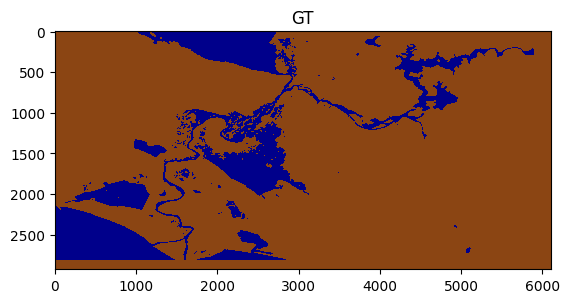

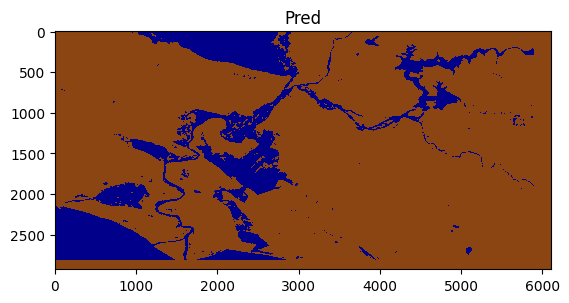

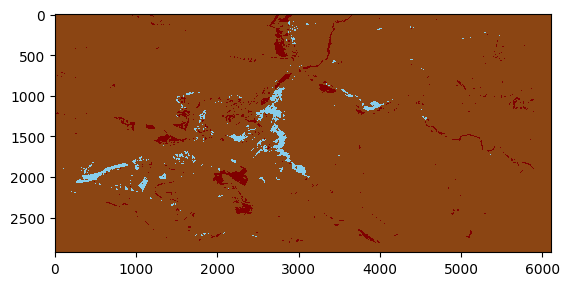

In [26]:
water_gt = torch.zeros_like(recombined_floods[1,:,:])
water = (recombined_floods[0,:,:] == 2) & (recombined_floods[1,:,:] == 2) & (recombined_floods[2,:,:] == 2)
water_gt[water] = 1
cmap = ListedColormap(['SaddleBrown', 'DarkBlue'])
plt.title('GT')
plt.imshow(water_gt, cmap=cmap)
plt.show()

water_pred = torch.zeros_like(prediction[:,:])
water_pred[prediction==2] = 1
cmap = ListedColormap(['SaddleBrown', 'DarkBlue'])
plt.title('Pred')
plt.imshow(water_pred, cmap=cmap)
plt.show()

water_diff = water_pred - water_gt
cmap = ListedColormap(['SkyBlue','SaddleBrown','Maroon'])
plt.imshow(water_diff, cmap=cmap)
plt.show()

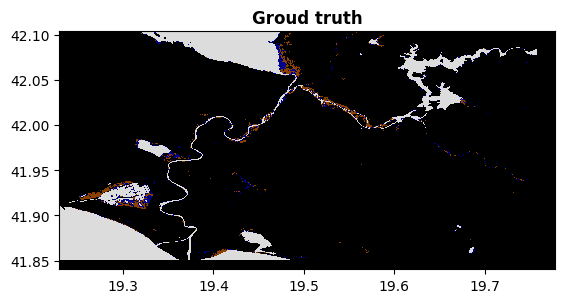

tensor([0., 0., 0.]) tensor([0., 1., 2., 3.])


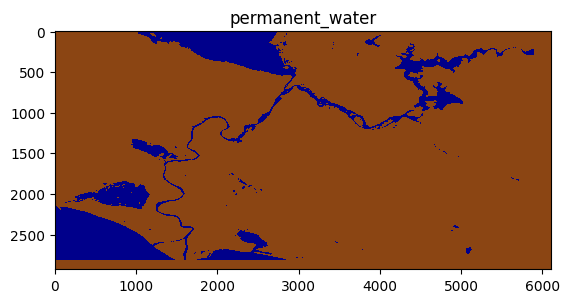

In [27]:
plot_utils.plot_gt_v1(recombined_water, transform=transform, title = "Groud truth")
print(recombined_water[:,0,0],recombined_water.unique())

permanent_water = torch.ones_like(recombined_water[0,:,:]) # {0:Land, 1:flood water, 2:seasonal water, 3:permanent water}
water = (recombined_water[0,:,:] == 0) & (recombined_water[1,:,:] == 0) & (recombined_water[2,:,:] == 0)
# print(len(torch.where(water)))
permanent_water[water] = 0
cmap = ListedColormap(['SaddleBrown', 'DarkBlue'])
plt.title('permanent_water')
plt.imshow(permanent_water, cmap=cmap)
plt.show()

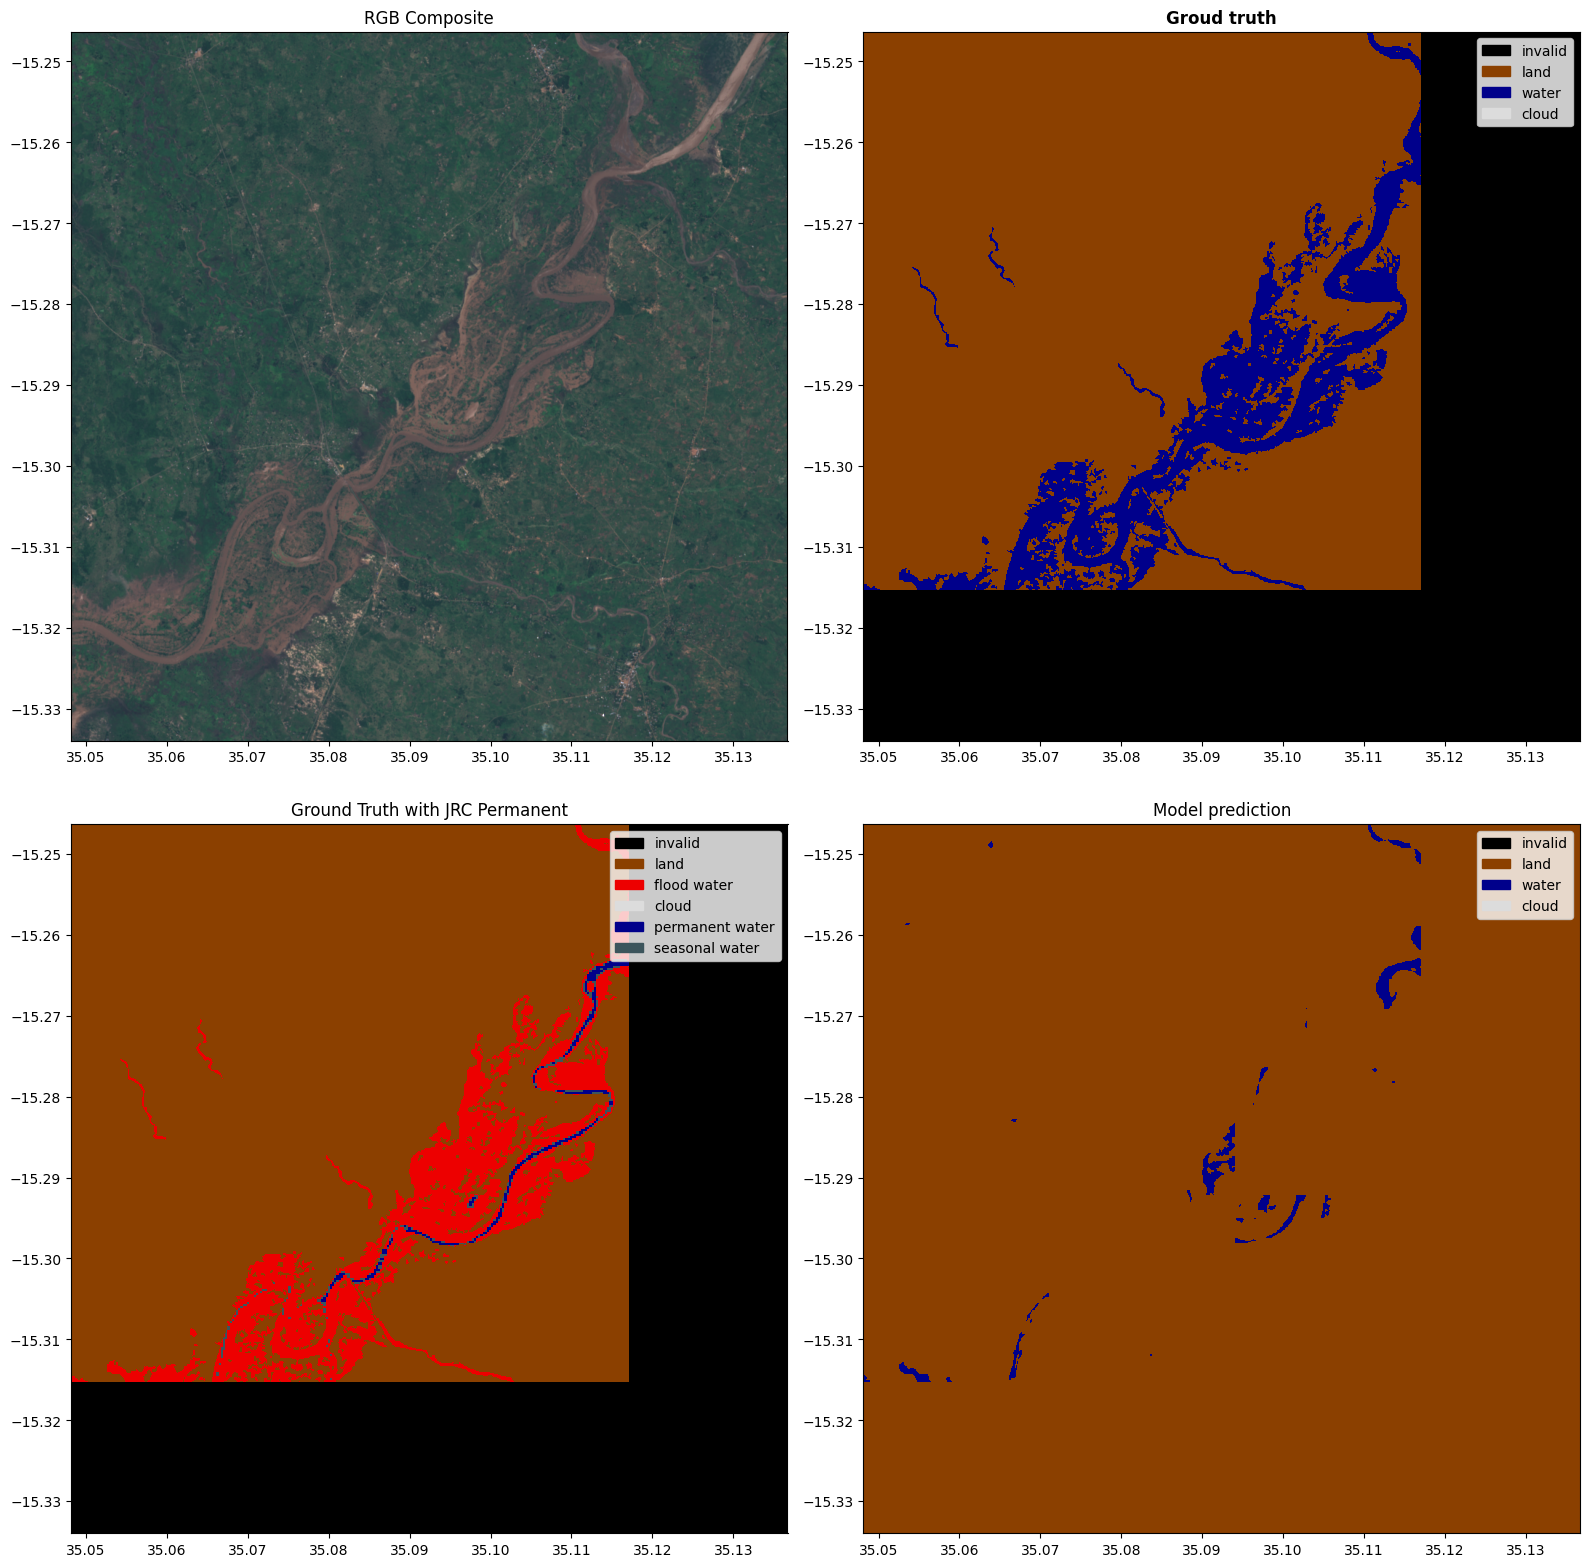

In [28]:
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt
# os.environ['GS_USER_PROJECT'] = 'myprojectname'

channel_configuration = config.model_params.hyperparameters.channel_configuration

dataset_folder = "./worldfloods_v1_0_sample/"
event_id = "EMSR347_07ZOMBA_DEL_v2_observed_event_a.tif"
tiff_s2 = os.path.join(dataset_folder, "tiffs_for_inference", "S2", event_id)
tiff_gt = os.path.join(dataset_folder, "tiffs_for_inference", "GT", event_id)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "tiffs_for_inference", "PERMANENTWATERJRC", event_id)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)
# print(torch_inputs.shape)
# Make predictions
sliced_images = slice_tensor(torch_inputs, size=256)
# print(sliced_images[0])
outs = []
for i in sliced_images:
    outputs = inference_function(i.unsqueeze(0))[0] # (num_classes, h, w)
    outs.append(outputs)
recombined_image = combine_slices(outs, torch_inputs.shape)    

prediction = torch.argmax(recombined_image, dim=0).long() # (h, w)
# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0

# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])
sliced_floods = slice_tensor(torch_targets, size=256)
recombined_floods = combine_slices(sliced_floods, torch_inputs.shape)    
# print(torch.unique(recombined_floods))
sliced_water = slice_tensor(torch_permanent_water, size=256)
recombined_water = combine_slices(sliced_water, torch_inputs.shape)   

# Plot
fig, axs = plt.subplots(2,2, figsize=(16,16))
plot_utils.plot_rgb_image(torch_inputs.squeeze(0), transform=transform, ax=axs[0,0], channel_configuration=channel_configuration)
axs[0,0].set_title("RGB Composite")
plot_utils.plot_gt_v1(recombined_floods, transform=transform, title = "Groud truth", ax=axs[0,1])

# axs[0,1].set_title("SWIR1,NIR,R Composite")
plot_utils.plot_gt_v1_with_permanent(recombined_floods, recombined_water, window=window, transform=transform, ax=axs[1,0])
axs[1,0].set_title("Ground Truth with JRC Permanent")
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, ax=axs[1,1])
axs[1,1].set_title("Model prediction")
plt.tight_layout()

In [29]:
# pred = prediction  # [1, 2, 3]
# # print(pred.shape, pred.unique())
# gt = recombined_floods[0,:,:]  # [0., 1., 2., 3.]
# # print(gt.shape, gt.unique())
# water = metrics_water(gt, pred)
# print(water)
# land = metrics_land(gt, pred)
# print(land)
# cloud = metrics_cloud(gt, pred)
# print(cloud)
# # score = F1_score(gt, pred)
# # print(score)

In [30]:
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt

channel_configuration = config.model_params.hyperparameters.channel_configuration
print(channel_configuration)

# dataset_folder = gs://ml4cc_data_lake/2_PROD/2_Mart/worldfloods_v1_0/

event_id = "EMSR501_AOI01_DEL_MONIT01_r1_v1.tif"
tiff_s2 = os.path.join(dataset_folder, "tiffs_for_inference", "S2", event_id)
tiff_gt = os.path.join(dataset_folder, "tiffs_for_inference", "GT","V_1_1", event_id)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "tiffs_for_inference", "JRC", event_id)

event_id_file_img = "EMSR501_AOI01_DEL_MONIT01_r1_v1.tif"
event_id_file_map = "EMSR501_AOI01_DEL_MONIT01_r1_v1.geojson"
tiff_s2 = os.path.join(dataset_folder, "tiffs_for_inference", "S2", event_id_file_img)
tiff_gt = os.path.join(dataset_folder, "val", "gt", event_id_file_img)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "val", "PERMANENTWATERJRC", event_id_file_img)
flood_map = os.path.join(dataset_folder, "val", "floodmaps", event_id_file_map)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)
sliced_images = slice_tensor(torch_inputs, size=256)
# Make predictions
outs = []
for i in sliced_images:
    outputs = inference_function(i.unsqueeze(0))[0] # (num_classes, h, w)
    outs.append(outputs)
recombined_image = combine_slices(outs, torch_inputs.shape)    
prediction = torch.argmax(recombined_image, dim=0).long() # (h, w)

# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0
# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])

sliced_floods = slice_tensor(torch_targets, size=256)
recombined_floods = combine_slices(sliced_floods, torch_inputs.shape)    

sliced_water = slice_tensor(torch_permanent_water, size=256)
recombined_water = combine_slices(sliced_water, torch_inputs.shape)    

# New Plot 
plot_utils.plot_rgb_image(torch_inputs, transform=transform,channel_configuration=channel_configuration, title = "RGB image")
plot_utils.plot_gt_v1(torch_targets, transform=transform, title = "Groud truth")
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, title = "Predict")
plot_utils.plot_gt_v1_wateronly(prediction.unsqueeze(0),transform=transform)

bgri


RasterioIOError: ./worldfloods_v1_0_sample/val/gt/EMSR501_AOI01_DEL_MONIT01_r1_v1.tif: No such file or directory

In [ ]:
plot_utils.plot_permanent(torch_permanent_water, transform=transform, channel_configuration=channel_configuration)

In [ ]:
plot_utils.plot_flood(prediction.unsqueeze(0),torch_permanent_water,transform=transform)

In [ ]:
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt

channel_configuration = config.model_params.hyperparameters.channel_configuration
print(channel_configuration)

# dataset_folder = gs://ml4cc_data_lake/2_PROD/2_Mart/worldfloods_v1_0/
event_id_file_img = "RS2_20161008_Water_Extent_Corail_Pestel.tif"
event_id_file_map = "RS2_20161008_Water_Extent_Corail_Pestel.geojson"
tiff_s2 = os.path.join(dataset_folder, "val", "S2", event_id_file_img)
tiff_gt = os.path.join(dataset_folder, "val", "gt", event_id_file_img)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "val", "PERMANENTWATERJRC", event_id_file_img)
flood_map = os.path.join(dataset_folder, "val", "floodmaps", event_id_file_map)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)
print('torch_input shape: ', torch_inputs.shape)
print('transform shape: ', transform)
sliced_images = slice_tensor(torch_inputs, size=256)
# Make predictions
outs = []
for i in sliced_images:
    outputs = inference_function(i.unsqueeze(0))[0] # (num_classes, h, w)
    outs.append(outputs)
recombined_image = combine_slices(outs, torch_inputs.shape)    
prediction = torch.argmax(recombined_image, dim=0).long() # (h, w)

# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0
# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])

sliced_floods = slice_tensor(torch_targets, size=256)
recombined_floods = combine_slices(sliced_floods, torch_inputs.shape)    

sliced_water = slice_tensor(torch_permanent_water, size=256)
recombined_water = combine_slices(sliced_water, torch_inputs.shape)    

# New Plot 
plot_utils.plot_rgb_image(torch_inputs, transform=transform,channel_configuration=channel_configuration, title = "RGB image")
plot_utils.plot_gt_v1(recombined_floods, transform=transform, title = "Groud truth")
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, title = "Predict")
plot_utils.plot_gt_v1_wateronly(prediction.unsqueeze(0),transform=transform)


In [ ]:
plot_utils.plot_permanent(torch_permanent_water, transform=transform, channel_configuration=channel_configuration)

In [ ]:
plot_utils.plot_flood(prediction.unsqueeze(0),torch_permanent_water,transform=transform)